In [1]:
import sys
sys.path.append('..')

import qiskit
import ansatz
from qimax import converter, constant

import numpy as np
from custom_lib import quantum_circuit_ctx_generator, utils, fixed_point_handler

%load_ext autoreload
%autoreload 2

In [30]:
def test_generate_quantum_circuit_data_with_state_res(num_qubits=3, quanvolutional_idx=1, basis_gate_list=['h', 's', 'cx', 'rx', 'ry', 'rz'], output_file_path='output.txt', output_state_path='output_state.txt'):
    qc = qiskit.QuantumCircuit(num_qubits) 

    if(quanvolutional_idx == 1):
        qc = ansatz.quanvolutional1(qc)
    elif(quanvolutional_idx == 2):
        qc = ansatz.quanvolutional2(qc)
    elif(quanvolutional_idx == 3):
        qc = ansatz.quanvolutional3(qc)
    elif(quanvolutional_idx == 4):
        qc = ansatz.quanvolutional4(qc)
    elif(quanvolutional_idx == 5):
        qc = ansatz.quanvolutional5(qc)
    elif(quanvolutional_idx == 6):
        qc = ansatz.quanvolutional6(qc)
    elif(quanvolutional_idx == 7):
        qc = ansatz.quanvolutional7(qc)
    elif(quanvolutional_idx == 8):
        qc = ansatz.quanvolutional8(qc)
    elif(quanvolutional_idx == 9):
        qc = ansatz.quanvolutional9(qc)
    elif(quanvolutional_idx == 10):
        qc = ansatz.quanvolutional10(qc)
    elif(quanvolutional_idx == 11):
        qc = ansatz.quanvolutional11(qc)
    elif(quanvolutional_idx == 12):
        qc = ansatz.quanvolutional12(qc)
    elif(quanvolutional_idx == 13):
        qc = ansatz.quanvolutional13(qc)
    elif(quanvolutional_idx == 14):
        qc = ansatz.quanvolutional14(qc)
    elif(quanvolutional_idx == 15):
        qc = ansatz.quanvolutional15(qc)
    elif(quanvolutional_idx == 16):
        qc = ansatz.quanvolutional16(qc)
    elif(quanvolutional_idx == 17):
        qc = ansatz.quanvolutional17(qc)
    elif(quanvolutional_idx == 18):
        qc = ansatz.quanvolutional18(qc)
    elif(quanvolutional_idx == 19):
        qc = ansatz.quanvolutional19(qc)
        
    qc = qiskit.transpile(circuits=qc, basis_gates=basis_gate_list, optimization_level=3)
    # qc.draw(output='mpl') # .savefig('qc.png')

    # Convert to readable files
    texts = []
    texts.append(len(qc.data))
    for gate in qc.data:
        name = gate.name.upper()
        params = None
        wires = converter.get_wires_of_gate(gate)

        if name == 'CX':
            type = 2
        else:
            type = 1
            gate_entries = constant.constant_gate[name]
            if name in ['RX', 'RY', 'RZ']:
                params = gate.params[0]
                gate_entries = gate_entries(params)
        texts.append(type)
        if type == 2:
            texts.append("{" + str(wires[0]) + ", "+ str(wires[1]) + "}")
            # texts.append(wires[1])
        else:
            texts.append(wires[0])
            texts.append(gate_entries[0][0])
            texts.append(gate_entries[0][1])
            texts.append(gate_entries[1][0])
            texts.append(gate_entries[1][1])

    with open(output_file_path, 'w') as f:
        for item in texts:
            f.write("%s\n" % item)

    #  RESULT FROM QISKIT
    qc_qiskit = (qiskit.quantum_info.Statevector.from_instruction(qc).data)
    # print(qc_qiskit)

    res_state = np.array(qc_qiskit)
    np.savetxt(output_state_path, res_state)
    # with open(output_state_path, 'w') as f:
    #     for item in res_state:
    #         f.write("%s\n" % item)

    return qc

def test_quantum_circuit_computation(n_qubit=3, n_quanv=1):
    ctx_link = './test/' + 'output_' + str(n_qubit) + '_qubits' + '_quanvolutional_' + str(n_quanv) + '.txt'
    gate_ctx_data = utils.read_file(ctx_link)

    I_matrix = np.array([[1, 0], [0, 1]], dtype=complex)
    Dense_matrix = np.array([[0, 0], [0, 0]], dtype=complex)

    state_vector = np.zeros(2**n_qubit, dtype=complex)
    state_vector[0] = 1

    bit_width = 32
    fraction_width = 30

    sub_idx = 0
    gate_type = 1 # 0: Sprase, 1: Dense, 2: CX
    num_of_gates = 0
    gate_count = 0
    for index, line in enumerate(gate_ctx_data):
        if index == 0: # Number of gates
            num_of_gates = int(line.strip())
            print(f"=> Number of gates: {num_of_gates}")
        else:
            if(sub_idx == 0): # Process gate type
                print(f"==================== Gate {gate_count} ====================")
                gate_count = gate_count + 1
                gate_type = int(line.strip())
                sub_idx = sub_idx + 1
            elif(sub_idx == 1):
                if(gate_type == 1): # Process dense gate position
                    pos = n_qubit-1-int(line.strip())
                    # pos = int(line.strip())
                    print(f"====> Dense gate | Pos: {pos}")
                    sub_idx = sub_idx + 1
                elif(gate_type == 2): # Process CX gate position
                    sub_idx = 0
                    ctrl_pos, tgt_pos = line.strip("{}").split(", ")
                    ctrl_pos = n_qubit-1-int(ctrl_pos)
                    tgt_pos = n_qubit-1-int(tgt_pos)
                    # ctrl_pos = int(ctrl_pos)
                    # tgt_pos = int(tgt_pos)

                    print(f"====> CX gate | Ctrl Pos: {ctrl_pos} | Tgt Pos: {tgt_pos}")

                    cx_matrix = utils.cx_matrix_formula(n_qubit, ctrl_pos, tgt_pos)
                    state_vector = np.dot(cx_matrix, state_vector)

                    print(f"State vector after CX gate:")
                    for i in range(2**n_qubit):
                        real_part = state_vector[i].real
                        imaginary_part = state_vector[i].imag

                        real_part_binary = fixed_point_handler.convert_fixedpoint_to_binary(number=real_part, bit_width=bit_width, dot_position=fraction_width)
                        imaginary_part_binary = fixed_point_handler.convert_fixedpoint_to_binary(number=imaginary_part, bit_width=bit_width, dot_position=fraction_width)

                        real_part_hex = fixed_point_handler.binary_to_hex(binary_str=real_part_binary, bit_width=bit_width)
                        imaginary_part_hex = fixed_point_handler.binary_to_hex(binary_str=imaginary_part_binary, bit_width=bit_width)
                        print(f"Complex number: {state_vector[i]} | Hex form: {real_part_hex[2:]+imaginary_part_hex[2:]}")
            else: # Process dense gate entries
                if(gate_type):
                    if(line[0] == '('):
                        line = line.strip("()")
                        
                    line = line.strip("")
                    compl_num = complex(line)

                    if(sub_idx == 2):
                        Dense_matrix[0][0] = compl_num
                    elif(sub_idx == 3):
                        Dense_matrix[0][1] = compl_num
                    elif(sub_idx == 4):
                        Dense_matrix[1][0] = compl_num
                    elif(sub_idx == 5):
                        Dense_matrix[1][1] = compl_num

                        full_dense_matrix = utils.create_full_gate_matrix(gate_matrix=Dense_matrix, gate_pos=pos, n_qubit=n_qubit)
                        state_vector = np.dot(full_dense_matrix, state_vector)
                        print(f"State vector after Dense gate:")
                        for i in range(2**n_qubit):
                            real_part = state_vector[i].real
                            imaginary_part = state_vector[i].imag

                            real_part_binary = fixed_point_handler.convert_fixedpoint_to_binary(number=real_part, bit_width=bit_width, dot_position=fraction_width)
                            imaginary_part_binary = fixed_point_handler.convert_fixedpoint_to_binary(number=imaginary_part, bit_width=bit_width, dot_position=fraction_width)

                            real_part_hex = fixed_point_handler.binary_to_hex(binary_str=real_part_binary, bit_width=bit_width)
                            imaginary_part_hex = fixed_point_handler.binary_to_hex(binary_str=imaginary_part_binary, bit_width=bit_width)
                            print(f"Complex number: {state_vector[i]} | Hex form: {real_part_hex[2:]+imaginary_part_hex[2:]}")

                    if(sub_idx < 5):
                        sub_idx = sub_idx + 1
                    else:
                        sub_idx = 0

In [3]:
utils.create_folder('test')

Directory 'test' created successfully.


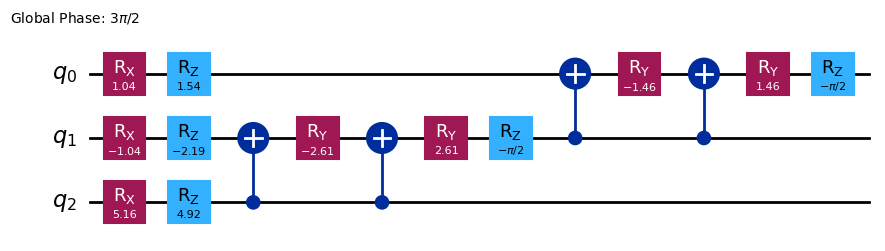

In [14]:
num_qubits=3
quanvolutional=3
basis_gate_list=['h', 's', 'cx', 'rx', 'ry', 'rz']

ctx_link = './test/' + 'output_' + str(num_qubits) + '_qubits' + '_quanvolutional_' + str(quanvolutional) + '.txt'
state_link = './test/' + 'output_state_' + str(num_qubits) + '_qubits' + '_quanvolutional_' + str(quanvolutional) + '.txt'

qc = test_generate_quantum_circuit_data_with_state_res(num_qubits=num_qubits, quanvolutional_idx=quanvolutional, basis_gate_list=['h', 's', 'cx', 'rx', 'ry', 'rz'], output_file_path=ctx_link, output_state_path=state_link)

qc.draw(output='mpl')

In [23]:
qc_qiskit = (qiskit.quantum_info.Statevector.from_instruction(qc).data)
print(qc_qiskit)

[ 0.3389834 +0.53788175j  0.30251174-0.20429299j -0.05746115+0.15658342j
 -0.35745582-0.14661795j -0.21919014-0.38930145j -0.2194231 +0.13285144j
 -0.03871895-0.04060219j  0.09734905-0.08609528j]


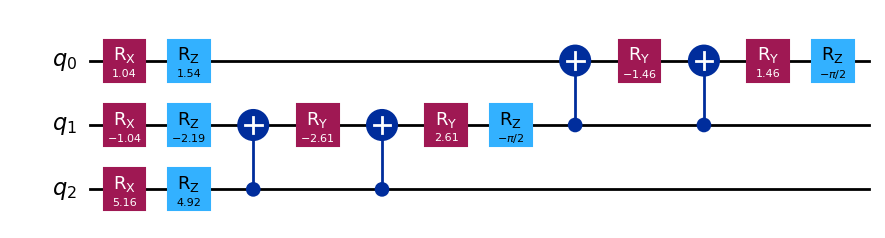

In [26]:
num_qubits=3
quanvolutional=3

qc_0 = qiskit.QuantumCircuit(num_qubits)
qc_0.rx(1.04, 0)
qc_0.rx(-1.04, 1)
qc_0.rx(5.16, 2)
qc_0.rz(1.54, 0)
qc_0.rz(-2.19, 1)
qc_0.rz(4.92, 2)
qc_0.cx(2, 1)
qc_0.ry(-2.61, 1)
qc_0.cx(2, 1)
qc_0.ry(2.61, 1)
qc_0.rz(-np.pi/2, 1)
qc_0.cx(1, 0)
qc_0.ry(-1.46, 0)
qc_0.cx(1, 0)
qc_0.ry(1.46, 0)
qc_0.rz(-np.pi/2, 0)

qc_0.draw(output='mpl')

In [27]:
qiskit_state_res = (qiskit.quantum_info.Statevector.from_instruction(qc_0).data)
print(qiskit_state_res)

ctx_link = './test/' + 'output_' + str(num_qubits) + '_qubits' + '_quanvolutional_' + str(quanvolutional) + '.txt'
state_link = './test/' + 'output_state_' + str(num_qubits) + '_qubits' + '_quanvolutional_' + str(quanvolutional) + '.txt'

texts = []
texts.append(len(qc_0.data))
for gate in qc_0.data:
    name = gate.name.upper()
    params = None
    wires = converter.get_wires_of_gate(gate)

    if name == 'CX':
        type = 2
    else:
        type = 1
        gate_entries = constant.constant_gate[name]
        if name in ['RX', 'RY', 'RZ']:
            params = gate.params[0]
            gate_entries = gate_entries(params)
    texts.append(type)
    if type == 2:
        texts.append("{" + str(wires[0]) + ", "+ str(wires[1]) + "}")
        # texts.append(wires[1])
    else:
        texts.append(wires[0])
        texts.append(gate_entries[0][0])
        texts.append(gate_entries[0][1])
        texts.append(gate_entries[1][0])
        texts.append(gate_entries[1][1])

with open(ctx_link, 'w') as f:
    for item in texts:
        f.write("%s\n" % item)

res_state = np.array(qiskit_state_res)
np.savetxt(state_link, res_state)

[-0.53864488+0.34086581j  0.20457053+0.30225179j -0.15725832-0.05725551j
  0.14509703-0.35750805j  0.38920754-0.21707963j -0.13109431-0.2189126j
  0.04119975-0.03808486j  0.08428956+0.09811373j]


In [31]:
test_quantum_circuit_computation(n_qubit=num_qubits, n_quanv=quanvolutional)

=> Number of gates: 16
==================== Gate 0 ====================
====> Dense gate | Pos: 2
State vector after Dense gate:
Complex number: (0.8678191796776499+0j) | Hex form: 378a597400000000
Complex number: -0.49688013784373675j | Hex form: 00000000e0331da7
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | Hex form: 0000000000000000
==================== Gate 1 ====================
====> Dense gate | Pos: 1
State vector after Dense gate:
Complex number: (0.7531101286163892+0j) | Hex form: 3032f4d300000000
Complex number: -0.4312021136216692j | Hex form: 00000000e4672f41
Complex number: 0.4312021136216692j | Hex form: 000000001b98d0bf
Complex number: (0.24688987138361082+0j) | Hex form: 0fcd0b2c00000000
Complex number: 0j | Hex form: 0000000000000000
Complex number: 0j | He